In [69]:
import numpy as np
import pandas as pd
#import asyncio
#import aiohttp
import json
import csv
import requests
import json
import time
from datetime import datetime
from datetime import date

In [70]:
pd.set_option('display.max_rows',10)

In [2]:
def get_markets(api = "cryptowatch", active = True):
    """get markets available in API"""
    if api == "cryptowatch":
        try:
            r = requests.get("https://api.cryptowat.ch/markets").json()['result']
            if (active):
                exchanges = {item['exchange'] for item in r if item['active'] is True}
            else:
                exchanges = {item['exchange'] for item in r}
        except:
            print("Error: disfunctional API from Cryptowatch")
            

    return exchanges

def get_pairs(api = "cryptowatch", active = True):
    """get pairs available in API"""
    if api == "cryptowatch":
        try:
            r = requests.get("https://api.cryptowat.ch/markets").json()['result']
            if (active):
                pairs = {item['pair'] for item in r if item['active'] is True}
            else:
                pairs = {item['pair'] for item in r}
        except:
            print("Error: disfunctional API from Cryptowatch")
    return pairs

In [3]:
def list_markets_containing_pair(pair='btcusd'):
    try:
        r = requests.get("https://api.cryptowat.ch/markets").json()['result']
        exchanges = {item['exchange'] for item in r if (item['active'] is True and item['pair'] == pair)}
        return exchanges
    except:
        print('error')

def list_pairs(pairs=get_pairs(), p1='btc'):
    pairs = list(pairs)
    L = []
    for pair in pairs:
        if p1 == pair[:len(p1)]:
            L.append(pair)
    return L

def list_pairs_in_market(market):
    r = requests.get("https://api.cryptowat.ch/markets/"+market).json()['result']
    market_pairs = {item['pair'] for item in r if item['active'] is True}
    return market_pairs

In [4]:
def get_ohlc(market, pair, period = 1440, api = "cryptowatch", start = "", end = "", local_timezone = True):
    """get OHLC prices available in API"""
    period *= 60
    period = str(period)
    params = []
    url = "https://api.cryptowat.ch/markets/" + market + "/" + pair + "/ohlc"
#    print(url)
    if (end == ""):
        before = ""
    else:
        before = time.mktime(time.strptime(end, "%d %m %y %H %M"))
    if (start == ""):
        after = start
    else:
        after = time.mktime(time.strptime(start, "%d %m %y %H %M"))
    if (not before or not after):
        prms = [('before', before), ('after', after)]
    else:
        prms = {'before': int(before) , 'after': int(after) }

    
    if api == "cryptowatch":
        try:
            r = requests.get(url, params=prms).json()['result'][period]
            if (local_timezone):            
                a = pd.DataFrame(r, columns = ['date(local)','open','high','low','close','volume','neg'])
                a[a.columns[0]] = pd.to_datetime(a[a.columns[0]] - time.timezone, unit = 's')
                a = a.set_index('date(local)')
 
                return a
            else:
                a = pd.DataFrame(r, columns = ['date(utc)','open','high','low','close','volume','neg'])
                a[a.columns[0]] = pd.to_datetime(a[a.columns[0]], unit = 's')
                a = a.set_index('date(utc)')

                return a               
                

        except:
            print("Error: disfunctional API from Cryptowatch")
            
#columns = ['period','open','high','low','close','volume','neg']    

In [5]:
def compare_pair_across_markets(pair = 'btcusd'):
    a = list_markets_containing_pair(pair)
    print(a)
    c = {}
    for m in list(a):
        print(m, pair)
        c[m] = get_ohlc(m,pair)
    return c

In [6]:
import os
import shutil

class Pair:
    markets = {}
    data = {}
    def __init__(self, name, start=0, end=time.time(), period=1440):
        self.name = str(name)
        self.period = period    
        self.start = start
        self.end = int(end)
        self.markets = list_markets_containing_pair(self.name)
        self.metadata = pd.DataFrame([period, start, end])
        
    

def download_pair_data(pair, force_update = False):
    try:
        os.mkdir(pair.name)
    except:
        try:
            m = pd.read_csv('pair_metadata.csv')
        except:
#        if not (m == pair.metadata).all():
            shutil.rmtree(pair.name)
            os.mkdir(pair.name)
        #print('m\n',m)
        #print('pair.metadata', pair.metadata)
        #if not (m == pair.metadata).all():
        #    shutil.rmtree(pair.name)
        #    os.mkdir(pair.name)
    
    #print(pair.markets)
    for key in list(pair.markets):
        pair.data[key].to_csv(pair.name+'/'+key+'.csv')
    
    pair.metadata.to_csv('pair_metadata.csv')

def load_pair_data(name, start = 0, end = time.time(), period = 1440):
    mkt = os.listdir(name)
    for i in range(len(mkt)):
        mkt[i] = mkt[i][0:-4]
    return mkt

In [62]:
def Timestamp_from_string(s='31 12 99'):
    #print(time.mktime(time.strptime(s, "%d %m %y")))
    return pd.Timestamp(int(time.mktime(time.strptime(s, "%d %m %y"))), unit='s')

In [91]:
def get_daily_price(asset="btc", api="coinmetrics", data_type="price(usd)", start=0, end=time.time()):
    if (api == "coinmetrics"):
        try:
            url =  "https://coinmetrics.io/api/v1/get_asset_data_for_time_range/"+asset+"/"+data_type
            url = url + "/"+str(int(start)) +"/"+str(int(end))
            r = requests.get(url).json()['result']
            a = pd.DataFrame(r, columns = ['date(utc)',str(asset)+" "+str(data_type)])
            #print(url)
            a[a.columns[0]] = pd.to_datetime(a[a.columns[0]], unit = 's')

            return a
        except:
            print("Error: disfunctional API from Coinmetrics")            
            
    else:
        return 0


def get_assets_from_coimetrics():
    url = 'https://coinmetrics.io/api/v1/get_supported_assets'
    r  = requests.get(url).json()
    return r

def get_whole_market_from_coimetrics():
    assets = get_assets_from_coimetrics()
    market = {}
    for asset in assets:
        market[asset] = get_daily_price(asset)
    return market

def merge_market_data(market, start=Timestamp_from_string('01 01 17')):
    '''merges the market data from the whole market, dumping coins which are too young '''
    assets = list(market.keys())
    #print(assets)
    #print(range(1,len(assets)))
    mkt = market[assets[0]]
    for i in range(1, len(assets)):
        if market[assets[i]]['date(utc)'][0] < start:
            mkt = pd.merge(mkt, market[assets[i]])
    
    return mkt

def rate_of_return(df):
    cols = df.columns
    #print(cols)
    if (type(df[cols[0]][0]) == pd.Timestamp):
        a = df[cols[1:]].values
        b = a/a[0, :]
        df2 = df[cols[0]]
        #df2 = pd.merge(df2, pd.Dataframe(b, columns = cols[1:]))
        #print(b)
        
        return b[-1]
    else:
        print('error return_from_values')

def get_coins_series(coins,start=Timestamp_from_string('01 01 17').timestamp()):
    returns = get_daily_price(coins[0], start=start)
    for i in range(1,len(coins)):
        returns = pd.merge(returns, get_daily_price(coins[i], start=start))
    return returns

 
def genetic_solver(w,cov,mean):
    size = len(mean)
    lr = .0005
    weights = np.reshape(np.tile(w,size),(size,size) )
    s = np.ones((size,size))*lr/2
    t = np.eye(size)*lr*1.5
    q = weights + t - s
    #a  = np.matmul(mean, q)
    a = np.matmul(q, mean)
    old_mean = np.matmul(mean,w)
    new_mean = a[np.argmin(a)]
    new_weight = q[np.argmin(a)]
    dif = (old_mean-new_mean)/old_mean

    if dif < 0.5 and np.abs(w) == w:
        return genetic_solver(new_weight, cov, mean)
    else:
        return new_weight



In [87]:
# para definir as taxas de base podemos obter os dados do mercado inteiro
market = get_whole_market_from_coimetrics()
# e unir todos a partir de uma dada data
mkt = merge_market_data(market, Timestamp_from_string('01 01 16'))

In [81]:
# montamos um portfolio com as seguintes moedas:
l = ['btc', 'ltc', 'eth']

#todas as opções podem ser obtidas em get_assets_from_coimetrics()

portfolio = get_coins_series(l)

mu = portfolio.mean()
sigma = portfolio.corr()


In [83]:
# geramos 1000 porfolios de forma aleatória:
L = 1000
s = np.zeros(L)
m = np.zeros(L)

for i in range(L):
    
    w1 = np.random.rand(3)
    w2 = np.sum(w1)
    w = w1/w2
    m[i] = np.matmul(mu, w)
    s[i] = np.sqrt( np.matmul(np.matmul(w, sigma), w) )



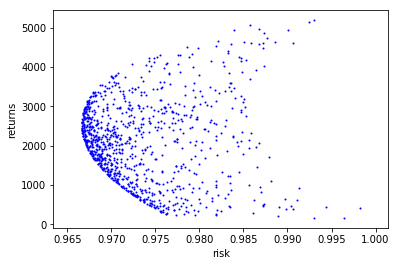

In [85]:
# fazemos um gráfico desses portfolios aleatórios
import matplotlib.pyplot as plt
plt.scatter(s,m,1,'b')
plt.ylabel('returns')
plt.xlabel('risk')
plt.show()

In [90]:
# para obter o portfolio de menor risco vamos usar a função ggenetic_solvertic_solver()
# mas ainda não está correta
z = genetic_solver([.4, .4, .2], sigma, mu)
z

array([-0.004,  1.208, -0.204])